In [1]:
import openfe
MyProtein = "./protein.pdb"
MyLigands = "20251117.sdf"
from rdkit import Chem
supp = Chem.SDMolSupplier(MyLigands, removeHs=False)
ligands = [openfe.SmallMoleculeComponent.from_rdkit(mol) for mol in supp]
from openfe.protocols.openmm_utils.omm_settings import OpenFFPartialChargeSettings
from openfe.protocols.openmm_utils.charge_generation import bulk_assign_partial_charges
charge_settings = OpenFFPartialChargeSettings(partial_charge_method="am1bcc", off_toolkit_backend="ambertools")
charged_ligands = bulk_assign_partial_charges(
    molecules=ligands,
    overwrite=False,
    method=charge_settings.partial_charge_method,
    toolkit_backend=charge_settings.off_toolkit_backend,
    generate_n_conformers=charge_settings.number_of_conformers,
    nagl_model=charge_settings.nagl_model,
    processors=18 #set number of Cpus
)

/home/zhennan/miniforge3/envs/openfe_env/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1518047) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/zhennan/miniforge3/envs/openfe_env/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1518047) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/zhennan/miniforge3/envs/openfe_env/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1518047) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/zhennan/miniforge3/envs/openfe_env/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1518047) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/zhennan/miniforge3/envs/openfe_env/lib/python3.12/multiprocessing/popen_fork.p

In [9]:
#存储charge信息至Desk
with open('charged_ligands.sdf', 'w') as f:  
    for mol in charged_ligands:  
        f.write(mol.to_sdf())  
        
import openfe
MyProtein = "./protein.pdb"
from rdkit import Chem
from openfecli.parameters.molecules import load_molecules  
charged_ligands = load_molecules('./charged_ligands.sdf')

In [10]:
charged_ligands

[SmallMoleculeComponent(name=20251106a-256),
 SmallMoleculeComponent(name=DY-0167),
 SmallMoleculeComponent(name=20251106a-276),
 SmallMoleculeComponent(name=20251106a-269),
 SmallMoleculeComponent(name=20251106a-286),
 SmallMoleculeComponent(name=20251106a-178),
 SmallMoleculeComponent(name=20251106a-176),
 SmallMoleculeComponent(name=20251106a-273),
 SmallMoleculeComponent(name=20251106a-228),
 SmallMoleculeComponent(name=20251106a-301),
 SmallMoleculeComponent(name=20251106a-174),
 SmallMoleculeComponent(name=20251106a-170),
 SmallMoleculeComponent(name=20251106a-59),
 SmallMoleculeComponent(name=20251106a-323),
 SmallMoleculeComponent(name=20251106a-222),
 SmallMoleculeComponent(name=20251106a-205),
 SmallMoleculeComponent(name=20251106a-124),
 SmallMoleculeComponent(name=20251106a-325),
 SmallMoleculeComponent(name=20251106a-327),
 SmallMoleculeComponent(name=20251106b-44),
 SmallMoleculeComponent(name=20251106b-51),
 SmallMoleculeComponent(name=20251106b-46),
 SmallMoleculeCompon

In [29]:
from openfe import setup

mapper = setup.KartografAtomMapper(  #1.7后默认的map方法
    atom_max_distance=0.5,           # 可根据分子大小调整  
    atom_map_hydrogens=True,  
    map_hydrogens_on_hydrogens_only=True,  
    map_exact_ring_matches_only=False,  # 关键:允许不完全环匹配  
    allow_partial_fused_rings=True,  
    allow_bond_breaks=True,             # 关键:允许键断裂  
)
scorer = setup.lomap_scorers.default_lomap_score

#network_planner = openfe.ligand_network_planning.generate_lomap_network
#network_planner = openfe.ligand_network_planning.generate_minimal_spanning_network
network_planner = openfe.ligand_network_planning.generate_radial_network
#network_planner = openfe.ligand_network_planning.generate_minimal_redundant_network

ligand_network = network_planner(
    #ligands=[charged_ligands[43], charged_ligands[45], charged_ligands[1], charged_ligands[23]],
    ligands=charged_ligands,
    mappers=[mapper],
    central_ligand="DY-0167", #for radial
    scorer=scorer
)

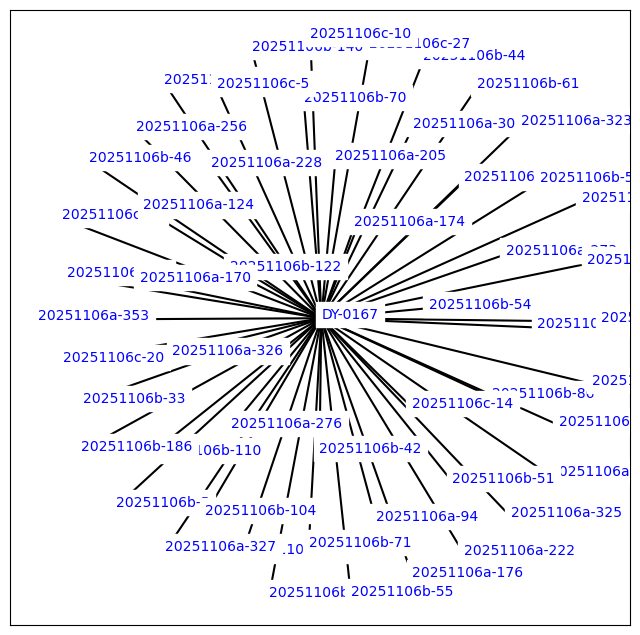

In [30]:
#show edge score
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network)

In [31]:

#show edge score
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network)

for mapping in ligand_network.edges:
    print(mapping.componentA, mapping.componentB, mapping.annotations)

#write map
with open("ligand_network.graphml", mode='w') as f:
    f.write(ligand_network.to_graphml())

SmallMoleculeComponent(name=DY-0167) SmallMoleculeComponent(name=20251106a-353) {'score': 0.8187307530779817}
SmallMoleculeComponent(name=DY-0167) SmallMoleculeComponent(name=20251106a-276) {'score': 0.023457028809379762}
SmallMoleculeComponent(name=DY-0167) SmallMoleculeComponent(name=20251106b-27) {'score': 0.02725317930340126}
SmallMoleculeComponent(name=DY-0167) SmallMoleculeComponent(name=20251106b-85) {'score': 0.06065306597126335}
SmallMoleculeComponent(name=DY-0167) SmallMoleculeComponent(name=20251106b-70) {'score': 0.7408182206817178}
SmallMoleculeComponent(name=DY-0167) SmallMoleculeComponent(name=20251106c-44) {'score': 0.49658530379140947}
SmallMoleculeComponent(name=DY-0167) SmallMoleculeComponent(name=20251106a-174) {'score': 0.04965853037914095}
SmallMoleculeComponent(name=DY-0167) SmallMoleculeComponent(name=20251106a-176) {'score': 0.7788007830714048}
SmallMoleculeComponent(name=DY-0167) SmallMoleculeComponent(name=20251106a-205) {'score': 0.23457028809379765}
SmallMo

In [32]:
#PROTOCOLs(simulation setting)
#define one tranformation frist
#the way to solvent and protein
solvent = openfe.SolventComponent()
protein = openfe.ProteinComponent.from_pdb_file(MyProtein)
#define system
systemA = openfe.ChemicalSystem({
    'ligand': mapping.componentA,
    'solvent': solvent,
    'protein': protein
})
systemB = openfe.ChemicalSystem({
    'ligand': mapping.componentB,
    'solvent': solvent,
    'protein': protein
})

#all your simulation parameter is writen in 'settings'
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol
settings = RelativeHybridTopologyProtocol.default_settings()

#mod paramter your want here!!!
from openff.units import unit
settings.protocol_repeats = 2
#settings.engine_settings.gpu_device_index = [1, 2, 3, 4, 5, 6] #multi GPU will make NaN.

protocol = RelativeHybridTopologyProtocol(settings)
#put everything of the protocol into 'transformation'
transformation = openfe.Transformation(
    systemA,
    systemB,
    protocol,
    mapping={'ligand': mapping},
)
#putting all the 'transformation's together in 'tranformations'
transformations = []
for mapping in ligand_network.edges:
    for leg in ['solvent', 'complex']:
        # use the solvent and protein created above
        sysA_dict = {'ligand': mapping.componentA,
                     'solvent': solvent}
        sysB_dict = {'ligand': mapping.componentB,
                     'solvent': solvent}

        if leg == 'complex':
            sysA_dict['protein'] = protein
            sysB_dict['protein'] = protein

        # we don't have to name objects, but it can make things (like filenames) more convenient
        sysA = openfe.ChemicalSystem(sysA_dict, name=f"{mapping.componentA.name}_{leg}")
        sysB = openfe.ChemicalSystem(sysB_dict, name=f"{mapping.componentB.name}_{leg}")

        prefix = "rbfe_"  # prefix is only to exactly reproduce CLI

        transformation = openfe.Transformation(
            stateA=sysA,
            stateB=sysB,
            mapping={'ligand': mapping},
            protocol=protocol,  # use protocol created above
            name=f"{prefix}{sysA.name}_{sysB.name}"
        )
        transformations.append(transformation)

network = openfe.AlchemicalNetwork(transformations)
#write 'transformations(input)'
import pathlib
transformation_dir = pathlib.Path("transformations")
transformation_dir.mkdir(exist_ok=True)
for transformation in network.edges:
    transformation.dump(transformation_dir / f"{transformation.name}.json")

/home/zhennan/miniforge3/envs/openfe_env/lib/python3.12/site-packages/gufe/transformations/transformation.py:196: DeprecationWarning: mapping input as a dict is deprecated; instead use either a single Mapping or list
  warnings.warn(
/home/zhennan/miniforge3/envs/openfe_env/lib/python3.12/site-packages/gufe/transformations/transformation.py:196: DeprecationWarning: mapping input as a dict is deprecated; instead use either a single Mapping or list
  warnings.warn(
/home/zhennan/miniforge3/envs/openfe_env/lib/python3.12/site-packages/gufe/transformations/transformation.py:196: DeprecationWarning: mapping input as a dict is deprecated; instead use either a single Mapping or list
  warnings.warn(
/home/zhennan/miniforge3/envs/openfe_env/lib/python3.12/site-packages/gufe/transformations/transformation.py:196: DeprecationWarning: mapping input as a dict is deprecated; instead use either a single Mapping or list
  warnings.warn(
/home/zhennan/miniforge3/envs/openfe_env/lib/python3.12/site-pac